<a href="https://colab.research.google.com/github/fabriciocarraro/CNN_Transfer-Learning_Fine-Tuning_VGG16_on_CIFAR10/blob/main/CNN_Transfer_Learning_Fine_Tuning_VGG16_on_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters

args = {
    'epochs': 10,
    'batch_size': 50,
    'lr': 1e-3,
    'weight_decay': 5e-4  # L2 regularization
}

args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", args['device'])

Using device: cuda


In [3]:
# Using "transforms" that match VGG16 expectations: 224x224 + normalization
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # The means from VGG
                         std=[0.229, 0.224, 0.225])   # The standard deviations from VGG
])

train_set = datasets.CIFAR10(
    root='.',
    train=True,
    transform=data_transform, # Applying VGG transform to CIFAR10
    download=True
)

test_set = datasets.CIFAR10(
    root='.',
    train=False,
    transform=data_transform, # Applying VGG transform to CIFAR10
    download=False
)

train_loader = DataLoader(train_set, batch_size=args['batch_size'], shuffle=True)
test_loader = DataLoader(test_set, batch_size=args['batch_size'], shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


Extracting ./cifar-10-python.tar.gz to .


In [4]:
# Loading the pretrained VGG16
net = models.vgg16_bn(pretrained=True).to(args['device'])
print("\nOriginal VGG16:\n")
print(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]



Original VGG16:

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14

In [5]:
# I want to replace only the last layer of the classifier. So I find its "in_features",
# then create a new classifier with everything but the last layer,
# and finally add a new Linear layer with "in_features" as input,
# and that outputs 10 classes (for CIFAR10)

in_features = list(net.children())[-1][-1].in_features
new_classifier = list(net.classifier.children())[:-1]
new_classifier.append(nn.Linear(in_features, 10))

# Finally, I replace the old classifier with the new one
net.classifier = nn.Sequential(*new_classifier).to(args['device'])
print("Modified VGG16 Classifier:\n")
print(net.classifier)

Modified VGG16 Classifier:

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


In [6]:
# For Optimizer and Loss, I can set a lower learning rate for the earlier layers
# and a higher one for the classifier layer

optimizer = optim.Adam(
    [
        {
            'params': net.features.parameters(),
            'lr': args['lr'] * 0.2,
            'weight_decay': args['weight_decay'] * 0.2
        },
        {
            'params': net.classifier.parameters(),
            'lr': args['lr'],
            'weight_decay': args['weight_decay']
        }
    ]
)

# Using the Cross Entropy Loss
criterion = nn.CrossEntropyLoss().to(args['device'])

In [7]:
##### Training function #####

def train(train_loader, net, epoch):
    # Setting the net for training
    net.train()

    start = time.time()

    epoch_loss  = []
    pred_list, label_list = [], []

    for k, batch in enumerate(train_loader):
        print('\rTraining batch: {}/{}'.format(k, len(train_loader)),
              end='', flush=True)

        sample, label = batch
        sample = sample.to(args['device'])
        label = label.to(args['device'])

        # Forward
        ypred = net(sample)
        loss = criterion(ypred, label)
        epoch_loss.append(loss.cpu().data)

        # Predictions for accuracy
        _, pred = torch.max(ypred, axis=1)
        pred_list.append(pred.cpu().numpy())
        label_list.append(label.cpu().numpy())

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = np.asarray(epoch_loss)
    pred_list  = np.asarray(pred_list).ravel()
    label_list  = np.asarray(label_list).ravel()
    acc = accuracy_score(pred_list, label_list)

    end = time.time()
    print('\nEpoch {} [Train]: Loss: {:.4f} ± {:.4f}, Acc: {:.2f}%, Time: {:.2f}s'.format(
        epoch,
        epoch_loss.mean(),
        epoch_loss.std(),
        acc * 100,
        end - start
    ))
    return epoch_loss.mean()


##### Validation function #####

def validate(test_loader, net, epoch):
    # Setting the net for validation
    net.eval()
    start = time.time()

    epoch_loss  = []
    pred_list, label_list = [], []

    with torch.no_grad():
        for k, batch in enumerate(test_loader):
            print('\rValidating batch: {}/{}'.format(k, len(test_loader)),
                  end='', flush=True)

            sample, label = batch
            sample = sample.to(args['device'])
            label = label.to(args['device'])

            # Forward
            ypred = net(sample)
            loss = criterion(ypred, label)
            epoch_loss.append(loss.cpu().data)

            # Predictions for accuracy
            _, pred = torch.max(ypred, axis=1)
            pred_list.append(pred.cpu().numpy())
            label_list.append(label.cpu().numpy())

    epoch_loss = np.asarray(epoch_loss)
    pred_list  = np.asarray(pred_list).ravel()
    label_list  = np.asarray(label_list).ravel()
    acc = accuracy_score(pred_list, label_list)

    end = time.time()
    print('\nEpoch {} [Validate]: Loss: {:.4f} ± {:.4f}, Acc: {:.2f}%, Time: {:.2f}s\n'.format(
        epoch,
        epoch_loss.mean(),
        epoch_loss.std(),
        acc * 100,
        end - start
    ))
    return epoch_loss.mean()

In [8]:
# Training

train_losses, test_losses = [], []

for epoch in range(args['epochs']):
    train_loss = train(train_loader, net, epoch)
    test_loss = validate(test_loader, net, epoch)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

Training batch: 999/1000
Epoch 0 [Train]: Loss: 0.5543 ± 0.2648, Acc: 82.20%, Time: 521.13s
Validating batch: 199/200
Epoch 0 [Validate]: Loss: 0.4883 ± 0.1437, Acc: 84.72%, Time: 41.14s

Training batch: 999/1000
Epoch 1 [Train]: Loss: 0.3210 ± 0.1278, Acc: 89.88%, Time: 519.66s
Validating batch: 199/200
Epoch 1 [Validate]: Loss: 0.3531 ± 0.1198, Acc: 88.61%, Time: 41.11s

Training batch: 999/1000
Epoch 2 [Train]: Loss: 0.2506 ± 0.1136, Acc: 92.18%, Time: 519.62s
Validating batch: 199/200
Epoch 2 [Validate]: Loss: 0.3208 ± 0.1380, Acc: 90.15%, Time: 41.29s

Training batch: 999/1000
Epoch 3 [Train]: Loss: 0.2142 ± 0.1170, Acc: 93.46%, Time: 519.64s
Validating batch: 199/200
Epoch 3 [Validate]: Loss: 0.4342 ± 0.1731, Acc: 87.35%, Time: 40.98s

Training batch: 999/1000
Epoch 4 [Train]: Loss: 0.1838 ± 0.1040, Acc: 94.46%, Time: 519.55s
Validating batch: 199/200
Epoch 4 [Validate]: Loss: 0.2913 ± 0.1370, Acc: 91.54%, Time: 41.04s

Training batch: 999/1000
Epoch 5 [Train]: Loss: 0.1606 ± 0.1

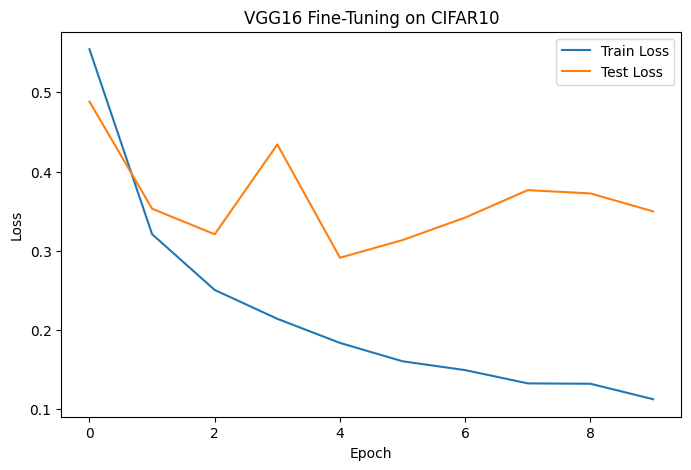

In [9]:
# Plot Loss Curves

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG16 Fine-Tuning on CIFAR10')
plt.legend()
plt.show()